# Red Neuronal Convolucional

Se esta utilizando un dataset privado y etiquetado para este proyecto

Se esta utilizando **VGG16**

*VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION*



*<font size="2">your_text_here</font>*

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.python.keras.optimizers import TFOptimizer
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense,BatchNormalization
from tensorflow.keras import models
from keras import initializers
from keras import backend as K
from PIL import Image

Using TensorFlow backend.


In [36]:
labels = pd.read_csv(r'../bbox_data.csv')
labels

,id,idn,Dataset Name,top,left,height,width,ancho,alto,y1,x1,y2,x2
0,0,100000101967.jpeg,parte1,69,81,118,270,1419,1419,0.048626,0.057082,0.083157,0.190275
1,1,100000321966.jpeg,parte1,1268,224,225,281,1731,1731,0.732525,0.129405,0.129983,0.162334
2,2,100000581968.jpeg,parte1,49,1127,196,256,1014,1014,0.048323,1.111440,0.193294,0.252465
3,3,100000111966.jpeg,parte1,148,720,149,353,1241,1241,0.119259,0.580177,0.120064,0.284448
4,4,100000351975.jpeg,parte1,57,1123,115,260,1051,1051,0.054234,1.068506,0.109420,0.247383
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2043,622069252020.jpeg,parte22,813,1873,303,862,4017,4017,0.202390,0.466268,0.075429,0.214588
2044,2044,621899412020.jpeg,parte22,815,1881,441,850,4017,4017,0.202888,0.468260,0.109783,0.211601
2045,2045,621936492020.jpeg,parte22,805,4465,1197,883,7796,7796,0.103258,0.572730,0.153540,0.113263
2046,2046,622006012020.jpeg,parte22,764,1884,438,906,4017,4017,0.190192,0.469007,0.109037,0.225541


In [46]:
def displayOne(id):
    img = mpimg.imread(r'../derimg/' + labels.iloc[id]['idn'])

    #plt.imshow(img)
    #plt.show()

    figure, ax = plt.subplots(1)
    bbox = patches.Rectangle((labels.iloc[id]['left'],labels.iloc[id]['top']),labels.iloc[id]['width'],labels.iloc[id]['height'], edgecolor='r', facecolor="none")
    ax.imshow(img)
    ax.add_patch(bbox)

    plt.figure(figsize=(30,30))
    plt.show()

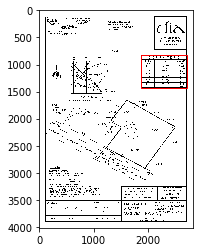

<Figure size 2160x2160 with 0 Axes>

In [47]:
displayOne(2000)

In [42]:
labels.iloc[0]

External ID     100000101967.jpeg
Dataset Name               parte1
top                            69
left                           81
height                        118
width                         270
Name: 0, dtype: object

In [24]:
(labels.iloc[0]['top'],labels.iloc[0]['left']),labels.iloc[0]['height'],labels.iloc[0]['width']

((1268, 224), 225, 281)

In [257]:
# Carga de bboxes
boxes = labels[['y1','x1','y2','x2']]
boxes = boxes.values

In [259]:
boxes.shape

(2048, 4)

In [2]:
def read_img(path, shape):
    img = Image.open(r"../train_img/derimg/" + path)
    img_size = img.size
    img = img.resize(shape, Image.ANTIALIAS)
    img = np.asarray(img)
    return img, img_size

#t = read_img(r'../train_img/derimg/100000101967.jpeg',(224,224))
#type(t)


#for traj in os.listdir(r"../train_img/derimg"):
#    cont += 1
trX = []
trName = []
trSize = []
cont = 0
for file in os.listdir(r"../train_img/derimg"):
    cont +=1
    print('Procesando: {};  \r'.format(cont), end="")
    #filename = os.path.basename(file_n)
    trName.append(file)
    img, img_size = read_img(file, (224, 224))
    trX.append(img)
    trSize.append(img_size)
len(trX)

2048

In [20]:
#len(trX[0])
#trX[0]
trX = np.array(trX, dtype=np.uint8)
trX.shape

(2048, 224, 224, 3)

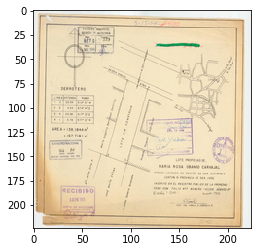

In [27]:
plt.imshow(trX[110])

In [29]:
len(trX[0][100])
trX[0][100][0:10]

array([[235, 235, 235],
       [235, 237, 236],
       [234, 238, 236],
       [231, 236, 237],
       [229, 226, 220],
       [230, 219, 196],
       [234, 223, 195],
       [233, 221, 195],
       [234, 222, 196],
       [233, 221, 195]], dtype=uint8)

In [30]:
#print(trX[0].shape)
trX = trX/255.


In [31]:
trX[0][100][0:10]

array([[0.92156863, 0.92156863, 0.92156863],
       [0.92156863, 0.92941176, 0.9254902 ],
       [0.91764706, 0.93333333, 0.9254902 ],
       [0.90588235, 0.9254902 , 0.92941176],
       [0.89803922, 0.88627451, 0.8627451 ],
       [0.90196078, 0.85882353, 0.76862745],
       [0.91764706, 0.8745098 , 0.76470588],
       [0.91372549, 0.86666667, 0.76470588],
       [0.91764706, 0.87058824, 0.76862745],
       [0.91372549, 0.86666667, 0.76470588]])

In [8]:
# save image reduction
#with open('img_values.npy', 'wb') as f:
#    np.save(f, trX)
# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed
# define data
# save to npy file
savez_compressed('img_values.npz', trX)
savez_compressed('names.npz', trName)
savez_compressed('sizes.npz', trSize)

In [3]:
#carga
from numpy import load
dict_data = load('img_values.npz')
trX = dict_data['arr_0']

dict_data = load('names.npz')
trName = dict_data['arr_0']

dict_data = load('sizes.npz')
trSize = dict_data['arr_0']

# print the array
print(len(trX))

2048


In [33]:
trX[20:25,20:25,1]

array([[[0.91372549, 0.92941176, 0.9254902 ],
        [0.92156863, 0.92941176, 0.92941176],
        [0.92156863, 0.93333333, 0.92941176],
        [0.92156863, 0.9372549 , 0.9254902 ],
        [0.92156863, 0.9372549 , 0.92941176]],

       [[0.8745098 , 0.8745098 , 0.84705882],
        [0.85490196, 0.85490196, 0.81960784],
        [0.87058824, 0.8745098 , 0.83529412],
        [0.8745098 , 0.86666667, 0.83529412],
        [0.87843137, 0.85882353, 0.83137255]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.27843137, 0.2627451 , 0.28235294],
        [0.26666667, 0.25490196, 0.27058824],
        [0.25490196, 0.25490196, 0.26666667],
        [0.24705882, 0.25098039, 0.2745098 ],
        [0.24705882, 0.24705882, 0.27843137]],

       [[0.94117647, 0.96078431, 0.94509804],
        [0.9372549 , 0.960

In [34]:
trName[0:10]

['100000011971.jpeg',
 '100000011973.jpeg',
 '100000021966.jpeg',
 '100000021968.jpeg',
 '100000021969.jpeg',
 '100000021971.jpeg',
 '100000021977.jpeg',
 '100000031968.jpeg',
 '100000031971.jpeg',
 '100000041977.jpeg']

In [42]:
fila = labels.loc[labels['idn'] == '100000011971.jpeg']
print(fila.values)
print(fila.values[0][9])
#yTrain.append([fila['y1'],fila['x1'],fila['y2'],fila['x2']])

[[12 '100000011971.jpeg' 'parte1' 104 594 131 273 1394 1394 0.074605452
  0.426111908 0.093974175 0.19583931100000002]]
0.074605452


In [37]:
yTrain = []
for item in trName:
    fila = labels.loc[labels['idn'] == item]
    t = fila.values[0]
    yTrain.append([t[9],t[10],t[11],t[12]])
yTrain = np.array(yTrain)
yTrain[0:10]

array([[0.07460545, 0.42611191, 0.09397417, 0.19583931],
       [0.09025641, 0.83282051, 0.31692308, 0.2625641 ],
       [0.07872175, 0.36944661, 0.1441933 , 0.20654716],
       [0.26199262, 0.39621771, 0.10055351, 0.18588561],
       [0.33304348, 0.88956522, 0.1773913 , 0.22608696],
       [0.04385965, 1.08089669, 0.11500975, 0.2582846 ],
       [0.8184699 , 0.14440923, 0.10774106, 0.12947035],
       [0.06774809, 1.05343512, 0.11068702, 0.24713741],
       [0.02931596, 1.18892508, 0.10162866, 0.1732899 ],
       [0.70700637, 0.14194723, 0.16014559, 0.24021838]])

In [261]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    #zoom_range=0.2,
)

# configuracion de imagenes de entrada para train
train_data = train_datagen.flow_from_directory(
    r'../small',
    target_size=(224,224), 
    batch_size=128,
    classes=None,
    class_mode=None,
    #interpolation='bicubic'
)

Found 4 images belonging to 1 classes.


In [5]:
files = ['100000101967.jpeg','100000321966.jpeg','100000581968.jpeg','100000111966.jpeg']
#files = ['derimg/100000101967.jpeg','derimg/100000321966.jpeg','derimg/100000581968.jpeg','derimg/100000111966.jpeg']
lb = [[0.048625793,0.057082452,0.083157153,0.190274841],
    [0.732524552,0.129404968,0.129982669,0.162333911],
    [0.048323471,1.111439842,0.193293886,0.252465483],
    [0.119258662,0.580177276,0.120064464,0.284448026]]
#lb = ['a','b','a','b']

'''
lb = np.array([[[0.048625793],[0.057082452],[0.083157153],[0.190274841]],
    [[0.732524552],[0.129404968],[0.129982669],[0.162333911]],
    [[0.048323471],[1.111439842],[0.193293886],[0.252465483]],
    [[0.119258662],[0.580177276],[0.120064464],[0.284448026]]])
'''
'''
lb = np.array([[0.048625793],
    [0.732524552],
    [0.048323471],
    [0.119258662],
    [0.048625793],
    [0.732524552],
    [0.048323471],
    [0.119258662]])
    '''

'''
lb = [[(0.048625793,0.057082452),(0.083157153,0.190274841)],
    [(0.732524552,0.129404968),(0.129982669,0.162333911)],
    [(0.048323471,1.111439842),(0.193293886,0.252465483)],
    [(0.119258662,0.580177276),(0.120064464,0.284448026)],
    [(0.048625793,0.057082452),(0.083157153,0.190274841)],
    [(0.732524552,0.129404968),(0.129982669,0.162333911)],
    [(0.048323471,1.111439842),(0.193293886,0.252465483)],
    [(0.119258662,0.580177276),(0.120064464,0.284448026)],
    ]
'''
y1 =[0.048625793,0.732524552,0.048323471,0.119258662]
x1 =[0.057082452,0.129404968,1.111439842,0.580177276]
y2 =[0.083157153,0.129982669,0.193293886,0.120064464]
x2 =[0.190274841,0.162333911,0.252465483,0.284448026]

#frame_data = pd.DataFrame(list(zip(files, y1,x1,y2,x2)), 
#               columns =['imagenes', 'y1','x1','y2','x2']) 
frame_data = pd.DataFrame(list(zip(files, lb)), 
               columns =['imagenes', 'boxes']) 

frame_data

,imagenes,boxes
0,100000101967.jpeg,"[0.048625793, 0.057082452, 0.083157153, 0.1902..."
1,100000321966.jpeg,"[0.732524552, 0.129404968, 0.129982669, 0.1623..."
2,100000581968.jpeg,"[0.048323471, 1.111439842, 0.193293886, 0.2524..."
3,100000111966.jpeg,"[0.119258662, 0.580177276, 0.120064464, 0.2844..."


In [265]:
lb[0]

[0.048625793, 0.057082452, 0.083157153, 0.190274841]

In [253]:
train_datagen = ImageDataGenerator(
    rescale=1./255.)

train_data = train_datagen.flow_from_dataframe(
    frame_data,
    directory='../train_img/derimg',
    x_col="imagenes",
    #y_col=list(map(tf.feature_column.numeric_column,['y1','x1','y2','x2'])),
    y_col='boxes',
    #classes=None,
    class_mode= 'categorical'
    # func
    #class_mode= 'multi_output', #None,
    #y_col=['y1','x1','y2','x2'],
    
    #y_col='asdf2',
)

Found 4 validated image filenames belonging to 2 classes.


In [226]:
#train_data[0][1]

In [6]:
cnn = Sequential()

cnn.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', name='uno')) 
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='dos')) 
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='tres')) 
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='cuatro')) 
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='cinco')) 
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(units=512, activation = 'relu', name='dense_uno'))

cnn.add(Dense(units=4, activation='softmax', name='dense_dos'))

In [7]:
# Compilador de la red
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
uno (Conv2D)                 (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
dos (Conv2D)                 (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
tres (Conv2D)                (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
cuatro (Conv2D)              (None, 24, 24, 64)       

In [9]:
print(trX.shape)
#print(lb.shape)
lb = np.array([[0.048625793,0.057082452,0.083157153,0.190274841],
    [0.732524552,0.129404968,0.129982669,0.162333911],
    [0.048323471,1.111439842,0.193293886,0.252465483],
    [0.119258662,0.580177276,0.120064464,0.284448026]])
lb.shape

(4, 224, 224, 3)


(4, 4)

In [38]:
vgg16 = Sequential(name='vgg16')

# Block1
vgg16.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding='same', name='block1_conv1')) 
vgg16.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', name='block1_conv2')) 
vgg16.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block1_pool'))

# Block 2
vgg16.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')) 
vgg16.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
vgg16.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
vgg16.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
vgg16.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

# Classification block
vgg16.add(Flatten(name='flatten'))
vgg16.add(Dense(4096, activation='relu', name='fc1'))
vgg16.add(Dense(4096, activation='relu', name='fc2'))
vgg16.add(Dense(4, activation='softmax', name='predictions'))

    

In [39]:
vgg16.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [40]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168

In [41]:
trX[0:10].shape, yTrain.shape

((10, 224, 224, 3), (2048, 4))

In [42]:
resultado = vgg16.fit(trX, yTrain,
                batch_size=16,
                #steps_per_epoch=16, 
                #validation_steps=16,
                #validation_steps=200,
                validation_split=0.2,
                #steps_per_epoch=25,
                #validation_steps=200,
                epochs=5,
                verbose=1)

Train on 1638 samples, validate on 410 samples
Epoch 1/5
1638/1638 [==============================] - 71s 43ms/step - loss: 0.1016 - accuracy: 0.8010 - val_loss: 0.0812 - val_accuracy: 0.9951
Epoch 2/5
1638/1638 [==============================] - 60s 37ms/step - loss: 0.1024 - accuracy: 0.8089 - val_loss: 0.0812 - val_accuracy: 0.9951
Epoch 3/5
1638/1638 [==============================] - 60s 37ms/step - loss: 0.1024 - accuracy: 0.8089 - val_loss: 0.0812 - val_accuracy: 0.9951
Epoch 4/5
1638/1638 [==============================] - 61s 37ms/step - loss: 0.1024 - accuracy: 0.8089 - val_loss: 0.0812 - val_accuracy: 0.9951
Epoch 5/5
1638/1638 [==============================] - 61s 37ms/step - loss: 0.1024 - accuracy: 0.8089 - val_loss: 0.0812 - val_accuracy: 0.9951


In [40]:
b_aprox = vgg16.predict(trX[50:55])
b_aprox

array([[0.14839792, 0.6062484 , 0.08792367, 0.15743002],
       [0.14839792, 0.6062484 , 0.08792367, 0.15743002],
       [0.14839792, 0.6062484 , 0.08792367, 0.15743002],
       [0.14839792, 0.6062484 , 0.08792367, 0.15743002],
       [0.14839792, 0.6062484 , 0.08792367, 0.15743002]], dtype=float32)

In [32]:
trX[1000:1002].shape

(2, 224, 224, 3)

In [110]:
list(map(tf.feature_column.numeric_column,['y1','x1','y2','x2']))

[NumericColumn(key='y1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='x1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='y2', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='x2', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

# Conclusiones

